# File structure

This project assumes the following initial file structure:

```
.\main                               
|   Preliminary data analysis.ipynb  
|   ...                              
|                                    
\---data                             
    \---olympic_sw_1896_2022         
            olympic_athletes.csv     
            olympic_hosts.csv        
            olympic_medals.csv       
            olympic_results.csv      
            olympic_results.pkl      
            ...                      
```

# Modules

## Imports

In [1]:
import os
import types
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pkg_resources
import pycountry
from geopy.geocoders import Nominatim
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

## Versions

The current module versions in use are as follows:

In [3]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name


imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

pd.DataFrame(requirements, columns=["Module", "Version"])

,Module,Version
0,geopy,2.4.1
1,matplotlib,3.9.2
2,numpy,1.26.4
3,pandas,2.2.2
4,pycountry,24.6.1
5,tqdm,4.66.5


# Global variables

The following global variables are used throughout the entirety of the methodology section.

In [4]:
DATA_PATH = "./data"
OLYMPIC_DATA_PATH = os.path.join(DATA_PATH, "olympic_sw_1896_2022")
CLEAN_DATA_PATH = os.path.join(DATA_PATH, "clean")

# Preliminary data analysis

In this section, we embark on a foundational exploration of our dataset to glean essential insights that underpin our research objectives. We outline the dataset's key attributes, including its size, composition, and structure, while examining descriptive statistics to uncover central tendencies and distributions.

## Data import

In [5]:
athletes_data = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_athletes.csv"))
medals_data = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_medals.csv"))
hosts_data = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_hosts.csv"))
results_data = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_results.csv"))

## Athletes

In [6]:
athletes_data.head()

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio
0,https://olympics.com/en/athletes/cooper-woods-...,Cooper WOODS-TOPALOVIC,1,Beijing 2022,2000.0,NaN,NaN
1,https://olympics.com/en/athletes/elofsson,Felix ELOFSSON,2,PyeongChang 2018,1995.0,NaN,NaN
2,https://olympics.com/en/athletes/dylan-walczyk,Dylan WALCZYK,1,Beijing 2022,1993.0,NaN,NaN
3,https://olympics.com/en/athletes/olli-penttala,Olli PENTTALA,1,Beijing 2022,1995.0,NaN,NaN
4,https://olympics.com/en/athletes/reikherd,Dmitriy REIKHERD,1,Beijing 2022,1989.0,NaN,NaN


In [7]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75904 entries, 0 to 75903
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   athlete_url           75904 non-null  object 
 1   athlete_full_name     75904 non-null  object 
 2   games_participations  75904 non-null  int64  
 3   first_game            75882 non-null  object 
 4   athlete_year_birth    73448 non-null  float64
 5   athlete_medals        15352 non-null  object 
 6   bio                   22842 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 4.1+ MB


In [8]:
athletes_data.describe(include=np.number)

,games_participations,athlete_year_birth
count,75904.000000,73448.000000
mean,1.535874,1961.619377
std,0.854563,28.129576
min,0.000000,1836.000000
25%,1.000000,1946.000000
50%,1.000000,1968.000000
75%,2.000000,1983.000000
max,10.000000,2009.000000


In [9]:
athletes_data.describe(include=object)

,athlete_url,athlete_full_name,first_game,athlete_medals,bio
count,75904,75904,75882,15352,22842
unique,75900,75480,53,170,22530
top,https://olympics.com/en/athletes/mariana-pajon,Ivan IVANOV,Rio 2016,\n\n\n1\n\nB\n\n,\n\n\nPersonal Best: Mar – unknown.\n\n\n\n\n\n
freq,2,4,4111,4209,110


The following code converts the `athlete_year_birth` column to the `Int64` data type, which is a pandas-specific integer type that supports nullable values. This ensures that the column contains integer values while allowing for `NaN` entries, providing better consistency for numerical operations involving birth years.

In [10]:
athletes_data["athlete_year_birth"] = athletes_data["athlete_year_birth"].astype("Int64")

The following code extracts information from the `first_game` column into two new columns, `first_game_host_city` and `first_game_year`, using a regular expression. The `.str.extract()` method is used with the regex pattern `r"^(.+?)\s(\d+?)$"` to capture the host city and the year separately. The pattern `^(.+?)\s(\d+?)$` matches the city name (which can contain spaces) followed by a space and a four-digit year, ensuring that both parts are properly captured. This allows us to split the `first_game` data into distinct columns for easier analysis.

In [11]:
athletes_data[["first_game_city", "first_game_year"]] = athletes_data[
    "first_game"
].str.extract(r"^(.+?)\s(\d+?)$")

athletes_data["first_game_year"] = athletes_data["first_game_year"].astype("Int64")

The following code extracts medal information from the `athlete_medals` column, converts it into structured medal counts, and stores these in new columns. First, the regex `.str.findall()` is used to extract medal pairs (number and type) from each string into the `medal_tuples` column. Next, a helper function `count_medals()` is defined to count specific medal types (`G`, `S`, `B`) in each list of tuples. This function is applied to create `bronze_count`, `silver_count`, and `gold_count` columns, representing the count of each medal type. Finally, a `total_medals` column is created by calculating the sum of the three newly created columns.

In [12]:
medal_tuples = athletes_data["athlete_medals"].str.findall(r"\n*(\d+)\n*([GSB])\n*")

In [13]:
def count_medals(medal_list, medal_type):
    if not isinstance(medal_list, list):
        return 0
    return sum(int(count) for count, medal in medal_list if medal == medal_type)

In [14]:
athletes_data["bronze_count"] = medal_tuples.apply(lambda x: count_medals(x, "B"))
athletes_data["silver_count"] = medal_tuples.apply(lambda x: count_medals(x, "S"))
athletes_data["gold_count"] = medal_tuples.apply(lambda x: count_medals(x, "G"))

athletes_data["total_medals"] = athletes_data[
    ["bronze_count", "silver_count", "gold_count"]
].sum(axis=1)

Here, we remove information that is redundant, or not pertinent for the present analysis.

In [15]:
athletes_data = athletes_data.drop(["first_game", "bio", "athlete_medals"], axis=1)

We add some extra columns based on the location.

In [16]:
geolocator = Nominatim(user_agent="city_to_country_mapper")
geocode = partial(geolocator.geocode, language="en")

def get_country(city, geocode=geocode):
    if pd.isna(city):
        return np.nan
    location = geocode(city)
    if location:
        return location.address.split(",")[-1].strip()
    else:
        return np.nan

def get_country_code(country_name):
    if pd.isna(country_name):
        return np.nan
    code = pycountry.countries.search_fuzzy(country_name)
    if code:
        return code[0].alpha_2
    else:
        return np.nan

In [17]:
cities = pd.Series(athletes_data["first_game_city"].unique())
countries = cities.progress_apply(get_country)
country_codes = countries.apply(get_country_code)

city_to_country = dict(zip(cities, countries))
city_to_country_code = dict(zip(cities, country_codes))

first_game_city_position = athletes_data.columns.get_loc("first_game_city")
athletes_data.insert(
    first_game_city_position + 1,
    "first_game_country",
    athletes_data["first_game_city"].map(city_to_country),
)
athletes_data.insert(
    first_game_city_position + 2,
    "first_game_country_code",
    athletes_data["first_game_city"].map(city_to_country_code),
)

  0%|          | 0/44 [00:00<?, ?it/s]

Finally, we visualize again, some preliminary informations of the entries of the resulting data frame.

In [18]:
athletes_data.head()

,athlete_url,athlete_full_name,games_participations,athlete_year_birth,first_game_city,first_game_country,first_game_country_code,first_game_year,bronze_count,silver_count,gold_count,total_medals
0,https://olympics.com/en/athletes/cooper-woods-...,Cooper WOODS-TOPALOVIC,1,2000,Beijing,China,CN,2022,0,0,0,0
1,https://olympics.com/en/athletes/elofsson,Felix ELOFSSON,2,1995,PyeongChang,South Korea,KR,2018,0,0,0,0
2,https://olympics.com/en/athletes/dylan-walczyk,Dylan WALCZYK,1,1993,Beijing,China,CN,2022,0,0,0,0
3,https://olympics.com/en/athletes/olli-penttala,Olli PENTTALA,1,1995,Beijing,China,CN,2022,0,0,0,0
4,https://olympics.com/en/athletes/reikherd,Dmitriy REIKHERD,1,1989,Beijing,China,CN,2022,0,0,0,0


In [19]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75904 entries, 0 to 75903
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   athlete_url              75904 non-null  object
 1   athlete_full_name        75904 non-null  object
 2   games_participations     75904 non-null  int64 
 3   athlete_year_birth       73448 non-null  Int64 
 4   first_game_city          75882 non-null  object
 5   first_game_country       75882 non-null  object
 6   first_game_country_code  75882 non-null  object
 7   first_game_year          75882 non-null  Int64 
 8   bronze_count             75904 non-null  int64 
 9   silver_count             75904 non-null  int64 
 10  gold_count               75904 non-null  int64 
 11  total_medals             75904 non-null  int64 
dtypes: Int64(2), int64(5), object(5)
memory usage: 7.1+ MB


In [20]:
athletes_data.describe(include=np.number)

,games_participations,athlete_year_birth,first_game_year,bronze_count,silver_count,gold_count,total_medals
count,75904.000000,73448.0,75882.0,75904.000000,75904.000000,75904.000000,75904.000000
mean,1.535874,1961.619377,1984.765742,0.109889,0.105844,0.109994,0.325727
std,0.854563,28.129576,28.683834,0.369809,0.380472,0.458560,0.851044
min,0.000000,1836.0,1896.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1946.0,1968.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1968.0,1992.0,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1983.0,2008.0,0.000000,0.000000,0.000000,0.000000
max,10.000000,2009.0,2022.0,6.000000,6.000000,23.000000,28.000000


In [21]:
athletes_data.describe(include=object)

,athlete_url,athlete_full_name,first_game_city,first_game_country,first_game_country_code
count,75904,75904,75882,75882,75882
unique,75900,75480,43,23,23
top,https://olympics.com/en/athletes/mariana-pajon,Ivan IVANOV,London,United States,US
freq,2,4,6113,9812,9812


In [22]:
athletes_data[athletes_data["first_game_city"].isna()]

,athlete_url,athlete_full_name,games_participations,athlete_year_birth,first_game_city,first_game_country,first_game_country_code,first_game_year,bronze_count,silver_count,gold_count,total_medals
926,https://olympics.com/en/athletes/mari-eder,Mari EDER,0,1987,NaN,NaN,NaN,<NA>,0,0,0,0
1595,https://olympics.com/en/athletes/slotins,Roberts SLOTINS,0,1991,NaN,NaN,NaN,<NA>,0,0,0,0
3447,https://olympics.com/en/athletes/oussama-mellouli,Oussama MELLOULI,0,1984,NaN,NaN,NaN,<NA>,0,0,0,0
5467,https://olympics.com/en/athletes/cathal-daniels,Cathal DANIELS,0,1996,NaN,NaN,NaN,<NA>,0,0,0,0
7286,https://olympics.com/en/athletes/klemen-bauer,Klemen BAUER,0,1986,NaN,NaN,NaN,<NA>,0,0,0,0
7288,https://olympics.com/en/athletes/julian-eberhard,Julian EBERHARD,0,1986,NaN,NaN,NaN,<NA>,0,0,0,0
7292,https://olympics.com/en/athletes/guigonnat,Antonin GUIGONNAT,0,1991,NaN,NaN,NaN,<NA>,0,0,0,0
7300,https://olympics.com/en/athletes/george-buta,George BUTA,0,1993,NaN,NaN,NaN,<NA>,0,0,0,0
7305,https://olympics.com/en/athletes/jeremy-finello,Jeremy FINELLO,0,1992,NaN,NaN,NaN,<NA>,0,0,0,0
7311,https://olympics.com/en/athletes/andrejs-rasto...,Andrejs RASTORGUJEVS,0,1988,NaN,NaN,NaN,<NA>,0,0,0,0


#### Inconsistencies

The following code drops rows with athletes who have no games_participations.

In [23]:
athletes_data = athletes_data[athletes_data["games_participations"] != 0]

Now, let's first take a look at the time stamps of the olympics as compared to athletes' ages.

In [24]:
game_years = pd.Series(
    pd.unique(athletes_data["first_game_year"].dropna())
).sort_values(ascending=True)

box_data_birth = []
box_data_age = []
for game_year in game_years:
    year_births = athletes_data[athletes_data["first_game_year"] == game_year][
        "athlete_year_birth"
    ].dropna()

    box_data_birth.append(year_births)
    box_data_age.append(game_year - year_births)

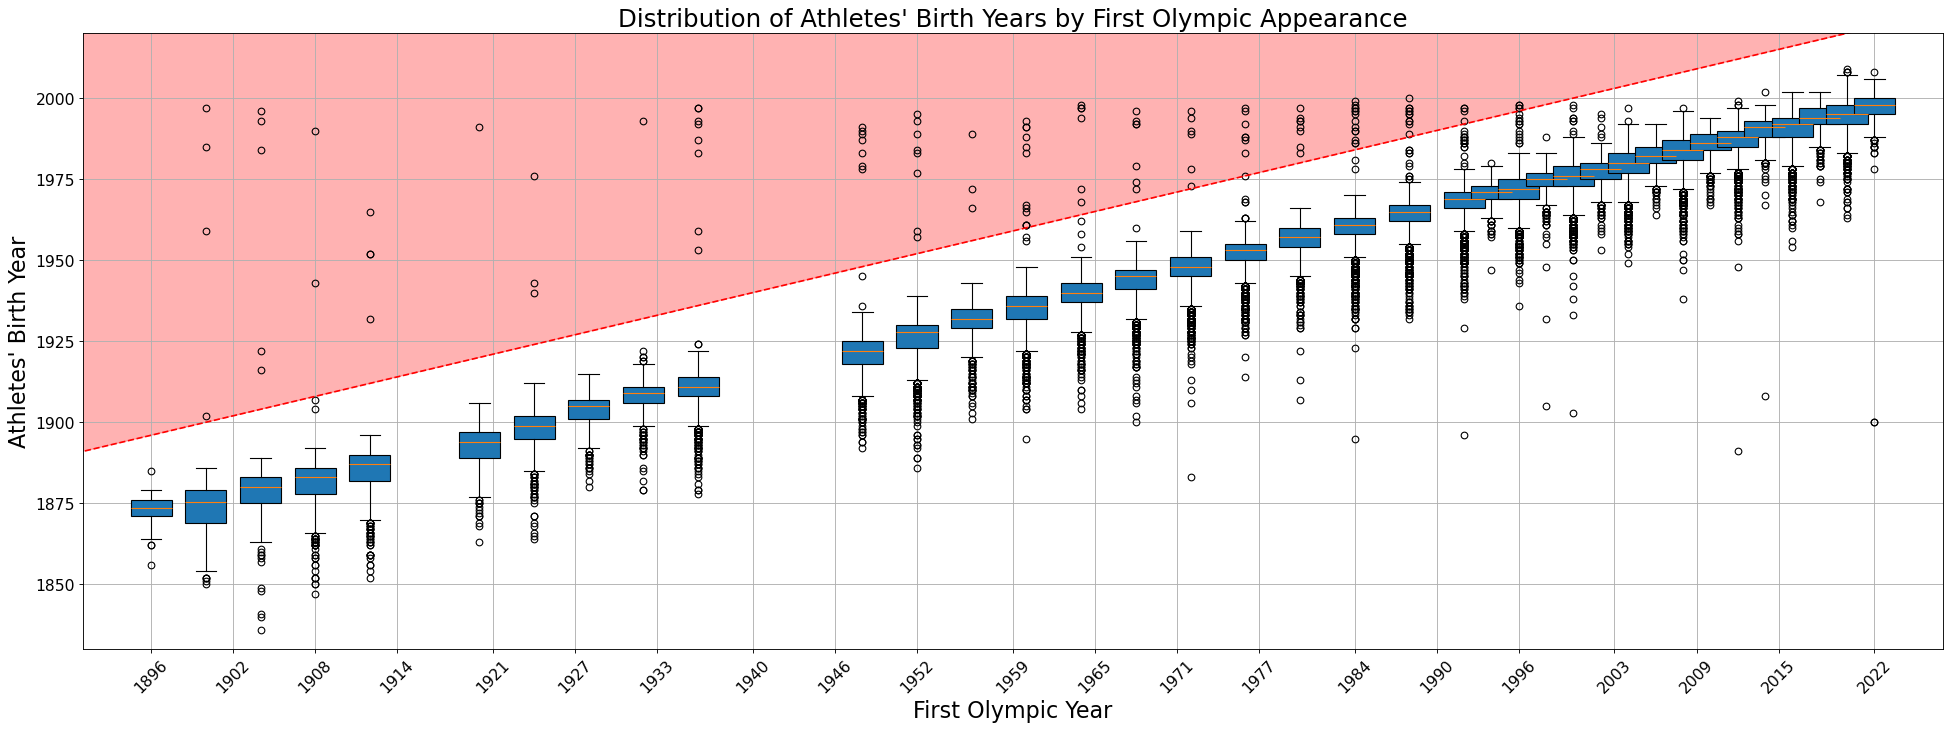

In [25]:
plt.figure(figsize=(30, 10), dpi=80)

plt.boxplot(
    box_data_birth,
    positions=game_years,
    widths=[3] * len(game_years),
    patch_artist=True,
    manage_ticks=False,
)

line_data = np.arange(min(game_years) / 1.1, 1.1 * max(game_years))
plt.plot(line_data, line_data, linestyle="--", c="red")
plt.fill_between(x=line_data, y1=line_data, y2=2040, alpha=0.3, color="red")

# Decoration
plt.title(
    "Distribution of Athletes' Birth Years by First Olympic Appearance", fontsize=22
)
plt.xlabel("First Olympic Year", fontsize=20)
plt.xticks(
    ticks=np.linspace(min(game_years), max(game_years), num=21, dtype=int),
    rotation=45,
    fontsize=14,
)
plt.xlim(min(game_years) - 5, max(game_years) + 5)
plt.yticks(fontsize=14)
plt.ylabel("Athletes' Birth Year", fontsize=20)
plt.ylim(1830, 2020)
plt.grid()
plt.show()

In [26]:
# References:
# https://eu.usatoday.com/story/sports/olympics/2022/11/24/who-is-youngest-olympian/10380713002/
# https://www.oldest.org/sports/olympians/
youngestOlympian = 10
oldestOlympian = 73

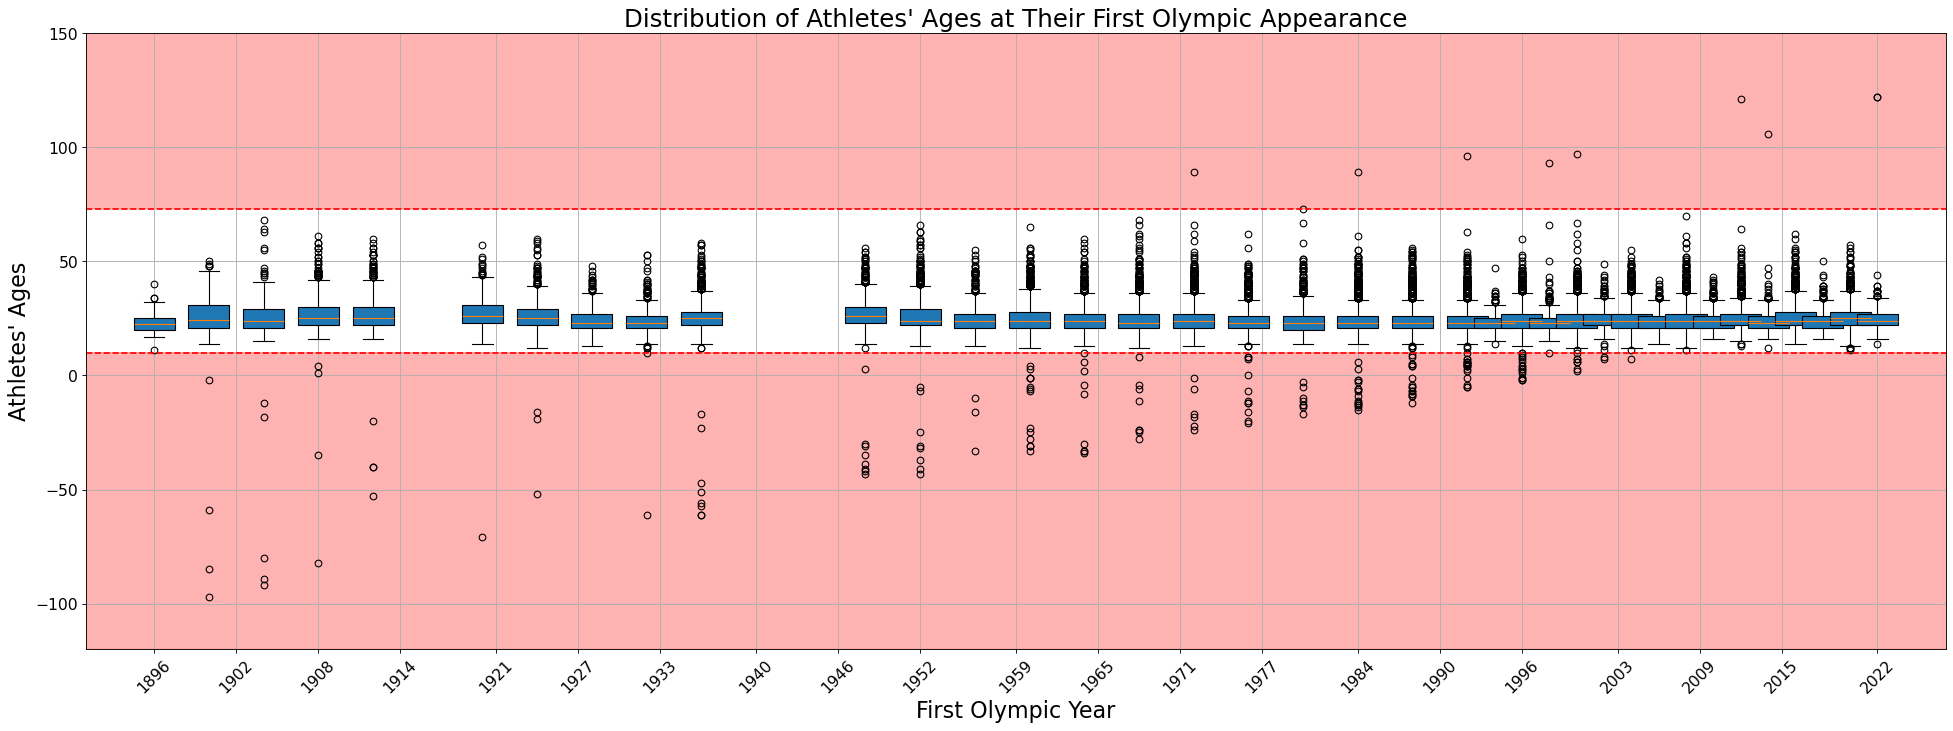

In [27]:
plt.figure(figsize=(30, 10), dpi=80)


plt.boxplot(
    box_data_age,
    positions=game_years,
    widths=[3] * len(game_years),
    patch_artist=True,
    manage_ticks=False,
)

line_data = np.arange(min(game_years) / 2, 2 * max(game_years))
plt.axhline(youngestOlympian, linestyle="--", c="red")
plt.fill_between(x=line_data, y1=youngestOlympian, y2=-120, alpha=0.3, color="red")

plt.axhline(oldestOlympian, linestyle="--", c="red")
plt.fill_between(x=line_data, y1=oldestOlympian, y2=150, alpha=0.3, color="red")

# Decoration
plt.title("Distribution of Athletes' Ages at Their First Olympic Appearance", fontsize=22)
plt.xlabel("First Olympic Year", fontsize=20)
plt.xticks(
    ticks=np.linspace(min(game_years), max(game_years), num=21, dtype=int),
    rotation=45,
    fontsize=14,
)
plt.xlim(min(game_years) - 5, max(game_years) + 5)
plt.yticks(fontsize=14)
plt.ylabel("Athletes' Ages", fontsize=20)
plt.ylim(-120, 150)
plt.grid()
plt.show()

In [28]:
ageAtFirstOlympiad = (
    athletes_data["first_game_year"] - athletes_data["athlete_year_birth"]
)
tooYoungOldOlympic = (ageAtFirstOlympiad < youngestOlympian) | (
    oldestOlympian < ageAtFirstOlympiad
)

In [29]:
print(f"We discovered at least {np.sum(tooYoungOldOlympic)} inconsistencies!")

We discovered at least 186 inconsistencies!


We remove the inconsistent data:

In [30]:
athletes_data = athletes_data.drop(athletes_data[tooYoungOldOlympic].index)

Let's now look at the athletes' names.

In [31]:
athletes_data["athlete_full_name"].sort_values()[:10]

9840                    DENI DENI
5312                       . DENI
6257                   . PRIYANKA
6502                      . RAHUL
31310              A Baser WASIQI
1265                     A J HURT
31995        A-Aziz Hassan JALOOF
67749                   A. DARNIS
64387         A. Germaine GOLDING
69797    A. Linger ANDREAS LINGER
Name: athlete_full_name, dtype: object

In our data, there are names which were abbreviated and names which start with uncommon characters such as spaces. We, thus, clean our data by: removing leading/trailing spaces, removing rows starting with a period

In [32]:
athletes_data["athlete_full_name"] = (
    athletes_data["athlete_full_name"]
    .str.replace(r"\s*\.\s*", "", regex=True)
    .str.strip()
    .str.upper()
)

In [33]:
countsDict = athletes_data["athlete_full_name"].value_counts().to_dict()

athletes_data["name_frequency"] = athletes_data.apply(lambda x: countsDict[x["athlete_full_name"]], axis=1)

athletes_data[athletes_data["name_frequency"] > 1].sort_values(
    by=["name_frequency", "athlete_full_name"], ascending=[False, True]
).head(10)

,athlete_url,athlete_full_name,games_participations,athlete_year_birth,first_game_city,first_game_country,first_game_country_code,first_game_year,bronze_count,silver_count,gold_count,total_medals,name_frequency
28156,https://olympics.com/en/athletes/francisco-san...,FRANCISCO SANCHEZ,2,1976,Atlanta,United States,US,1996,0,0,0,0,4
44334,https://olympics.com/en/athletes/francisco-san...,FRANCISCO SANCHEZ,1,1958,Moscow,Russia,RU,1980,0,0,0,0,4
47128,https://olympics.com/en/athletes/francisco-san...,FRANCISCO SANCHEZ,1,1956,Montreal,Canada,CA,1976,0,0,0,0,4
72475,https://olympics.com/en/athletes/francisco-san...,FRANCISCO SANCHEZ,3,1965,Seoul,South Korea,KR,1988,0,0,1,1,4
15863,https://olympics.com/en/athletes/hao-wang-5,HAO WANG,3,1983,Athens,Greece,GR,2004,0,3,2,5,4
18819,https://olympics.com/en/athletes/hao-wang-4,HAO WANG,1,1989,Beijing,China,CN,2008,0,0,0,0,4
40755,https://olympics.com/en/athletes/hao-wang-3,HAO WANG,1,1962,Los Angeles,United States,US,1984,0,0,0,0,4
69809,https://olympics.com/en/athletes/hao-wang-2,HAO WANG,1,1992,London,United Kingdom,GB,2012,0,0,1,1,4
12242,https://olympics.com/en/athletes/ivan-ivanov-8,IVAN IVANOV,1,1989,Rio,Brazil,BR,2016,0,0,0,0,4
18714,https://olympics.com/en/athletes/ivan-ivanov,IVAN IVANOV,1,1986,Beijing,China,CN,2008,0,0,0,0,4


In [34]:
print(
    f"We discovered {len(athletes_data[athletes_data["name_frequency"] > 1]["athlete_full_name"].unique())} with repeated rows"
)
print(f"We discovered at least {len(athletes_data[athletes_data["name_frequency"] > 1])} inconsistencies!")

We discovered 374 with repeated rows
We discovered at least 795 inconsistencies!


We drop the rows with duplicate names, retaining only the first occurrence of each unique name.

In [35]:
athletes_data = athletes_data.drop_duplicates(
    subset=["athlete_full_name"], keep="first"
)

athletes_data = athletes_data.drop("name_frequency", axis=1)

Let's finally take a look at athlete's URL's.

In [36]:
print(f"Total number of entries: {len(athletes_data)}")
print(f"Number of unique names: {len(athletes_data["athlete_full_name"].unique())}")
print(f"Number of unique URLs: {len(athletes_data["athlete_url"].unique())}")
print(
    f"Difference: {len(athletes_data["athlete_full_name"].unique()) - len(athletes_data["athlete_url"].unique())}"
)

Total number of entries: 75275
Number of unique names: 75275
Number of unique URLs: 75272
Difference: 3


We drop the rows with duplicate athlete URL, retaining only the first occurrence of each unique URL.

In [37]:
athletes_data = athletes_data.drop_duplicates(subset=["athlete_url"], keep="first")

Finally, we save our cleaned data.

In [38]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75272 entries, 0 to 75903
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   athlete_url              75272 non-null  object
 1   athlete_full_name        75272 non-null  object
 2   games_participations     75272 non-null  int64 
 3   athlete_year_birth       72821 non-null  Int64 
 4   first_game_city          75272 non-null  object
 5   first_game_country       75272 non-null  object
 6   first_game_country_code  75272 non-null  object
 7   first_game_year          75272 non-null  Int64 
 8   bronze_count             75272 non-null  int64 
 9   silver_count             75272 non-null  int64 
 10  gold_count               75272 non-null  int64 
 11  total_medals             75272 non-null  int64 
dtypes: Int64(2), int64(5), object(5)
memory usage: 7.6+ MB


In [39]:
athletes_data.to_csv(os.path.join(CLEAN_DATA_PATH, "olympic_athletes.csv"), index=False)

## Medals

## Hosts

## Results